---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Batch Normalization Layer

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

In [9]:
from layer.normalization import BatchNormalization

---

# Activation layer

In [10]:
from layer.activation import (
    ReLU,
    Sigmoid
)

---

# Classification

In [35]:
%reload_ext autoreload
%autoreload 2
from data import (
    linear_separable,
    linear_separable_sectors,
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

from common.function import (
    transform_X_T,
    prediction_grid_2d
)
from layer.constants import (
    _WEIGHTS,
    _NAME,
    _SCHEME,
    _OPTIMIZER,
    _NUM_NODES,
    _NUM_FEATURES,
    _PARAMETERS,
    _LOSS_FUNCTION,
    _COMPOSITE_LAYER_SPEC,
    _LOG_LEVEL
)
from optimizer import (
    SGD
)
from network.sequential import (
    SequentialNetwork
)

---

# Categorical Classification Non-Linearly separable data

In [36]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from drawing import (
    plot,
    scatter
)

## Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


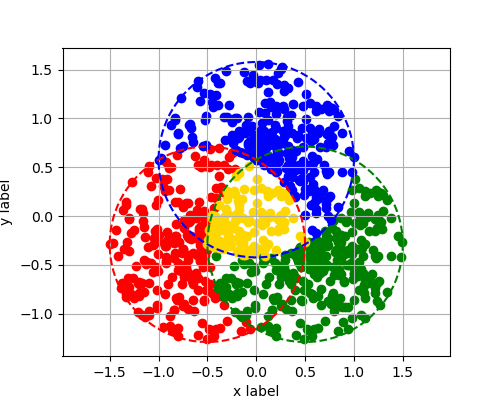

In [18]:
__M = 3        # Number of circles
__N = 500
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.0, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')
plt.draw()
plt.show()


In [19]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]
X, T = transform_X_T(X, T)
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

print(f"X:{X.shape} T:{T.shape} ")

X:(1001, 2) T:(1001,) 


## Construct a neural network

In [21]:
MAX_TEST_TIMES = 10000
D = 2
M01 = 8
M02: int = M  # Number of categories to classify
    
W01 = he(M01, D+1)
W02 = he(M02, M01+1)

### Compose a neural network specification

In [22]:
sequential_layer_specification = {
    "matmul01": Matmul.specification(
        name="matmul01", 
        num_nodes=M01, 
        num_features=D, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "relu01": ReLU.specification(
        name="relu01", 
        num_nodes=M01,     
    ),
    "matmul02": Matmul.specification(
        name="matmul02", 
        num_nodes=M02, 
        num_features=M01, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}

network_specification = {
    _NAME: "two_layer_classifier",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification
}
#import json
#print(json.dumps(network_specification, indent=4))

### Instantiate the network

In [23]:
network = SequentialNetwork(
    specification=network_specification,
)

# Reset the weights to use the same later in the batch normazliation version
network.layer_inference.layers[0]._W = copy.deepcopy(W01) 
network.layer_inference.layers[2]._W = copy.deepcopy(W02) 

np.array_equal(W01, network.layer_inference.layers[0].W) and \
np.array_equal(W02, network.layer_inference.layers[2].W)

True

## Run training

In [24]:
for i in range(MAX_TEST_TIMES):
    network.train(X=X, T=T)
    if not (i % 1000): 
        print(f"iteration {i} Loss {network.L}")

iteration 0 Loss 1.3576853496274783
iteration 1000 Loss 0.26745195922885096
iteration 2000 Loss 0.2311244494537049
iteration 3000 Loss 0.21765960327355344
iteration 4000 Loss 0.20809834161547036
iteration 5000 Loss 0.1995095511292477
iteration 6000 Loss 0.19124437615982748
iteration 7000 Loss 0.18264984826744418
iteration 8000 Loss 0.1735871226306872
iteration 9000 Loss 0.16473479572926594


### Plot training error

<IPython.core.display.Javascript object>


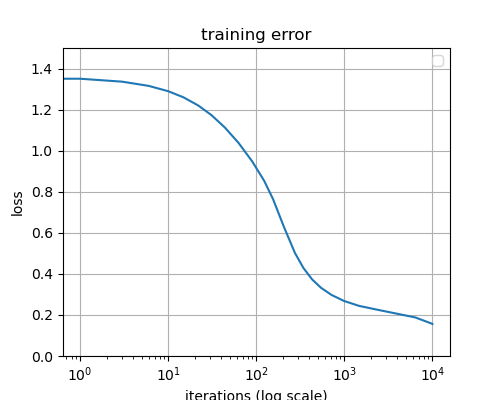

No handles with labels found to put in legend.


In [25]:
_x = range(len(network.history))
_y = network.history
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error"
fig, ax = plot(_x, _y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(5,4))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')

## Run predictions

<IPython.core.display.Javascript object>


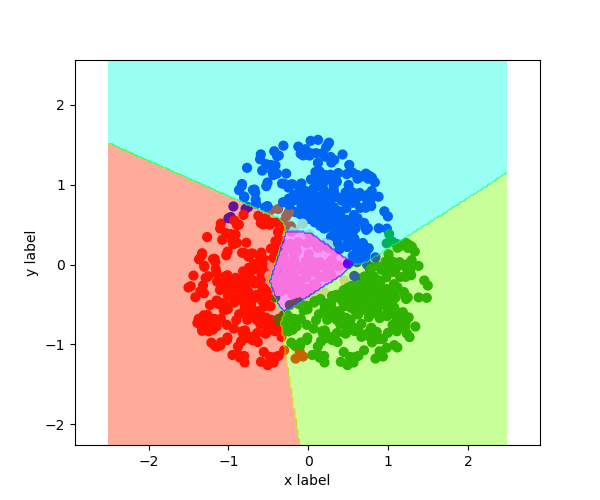

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/function.py:69: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [26]:
fig, ax = plt.subplots(figsize=(6,5)) 
x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, network.predict)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

# Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.

### Compose the neural network specification

In [27]:
sequential_layer_specification_bn = {
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "bn01": BatchNormalization.specification(
        name="bn01",
        num_nodes=M01,
        gamma_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        ),
        beta_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3,
        ),
        momentum=0.9
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M02,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "bn02": BatchNormalization.specification(
        name="bn02",
        num_nodes=M02,
        gamma_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        ),
        beta_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3,
        ),
        momentum=0.9
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_bn = {
    _NAME: "two_layer_classifier_with_batch_normalization",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_bn
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

### Instantiate the network

In [28]:
network_bn = SequentialNetwork(
    specification=network_specification_bn,
)

# Use the same weights used in non-batch-normalization network
network_bn.layer_inference.layers[0]._W = copy.deepcopy(W01)
network_bn.layer_inference.layers[3]._W = copy.deepcopy(W02)

np.array_equal(W01, network_bn.layer_inference.layers[0].W) and\
np.array_equal(W02, network_bn.layer_inference.layers[3].W)

True

## Run training

In [29]:
for i in range(MAX_TEST_TIMES):
    network_bn.train(X=X, T=T)
    if not (i % 1000): 
        print(f"iteration {i} Loss {network_bn.L}")

iteration 0 Loss 1.665615358339515
iteration 1000 Loss 0.19805279381018823
iteration 2000 Loss 0.16066886475758688
iteration 3000 Loss 0.12728506145307214
iteration 4000 Loss 0.09311906461463251
iteration 5000 Loss 0.08260184929299631
iteration 6000 Loss 0.0761034702242784
iteration 7000 Loss 0.0718243280038512
iteration 8000 Loss 0.06857845501911655
iteration 9000 Loss 0.06591704775441085


### Plot training error

<IPython.core.display.Javascript object>


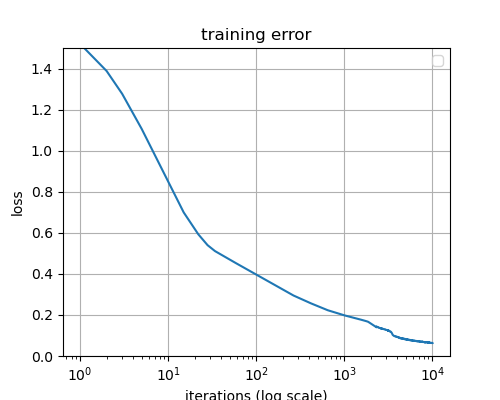

No handles with labels found to put in legend.


In [30]:
_x = range(len(network_bn.history))
_y = network_bn.history
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error"
fig, ax = plot(_x, _y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(5,4))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')

## Run predictions

<IPython.core.display.Javascript object>


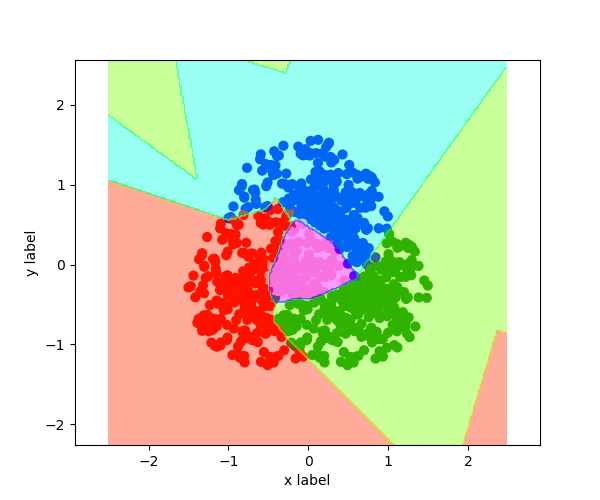

In [31]:
fig, ax = plt.subplots(figsize=(6,5)) 
x_grid, y_grid, predictions_bn = prediction_grid_2d(
    x_min, x_max, y_min, y_max, network_bn.predict
)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions_bn)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

## Using MD

Modified standardize
```
    # --------------------------------------------------------------------------------
    # Using MD instead of SD
    # --------------------------------------------------------------------------------
    # TODO remove from here
    # md = np.sum(np.abs(deviation), axis=0) / N
    # mask = (md < 1e-8)
    # if np.any(mask):
    #     md[mask] = TYPE_FLOAT(1.0)
    #     standardized = np.divide(deviation, md, out)
    # else:
    #     standardized = np.divide(deviation, md, out)
    #
    # return standardized, mean, md, deviation
    # # To here
    # --------------------------------------------------------------------------------
```

iteration 0 Loss 1.8115237901199528
iteration 1000 Loss 0.17125688641897918
iteration 2000 Loss 0.20159186508788327
iteration 3000 Loss 0.19594683891588507
iteration 4000 Loss 0.23122729020634306
iteration 5000 Loss 0.18342887087782148
iteration 6000 Loss 0.17266727041587124
iteration 7000 Loss 0.14658085928080578
iteration 8000 Loss 0.15463674633823693
iteration 9000 Loss 0.14035478092559653


<IPython.core.display.Javascript object>


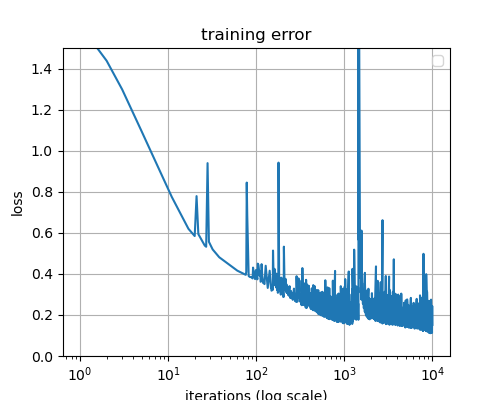

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


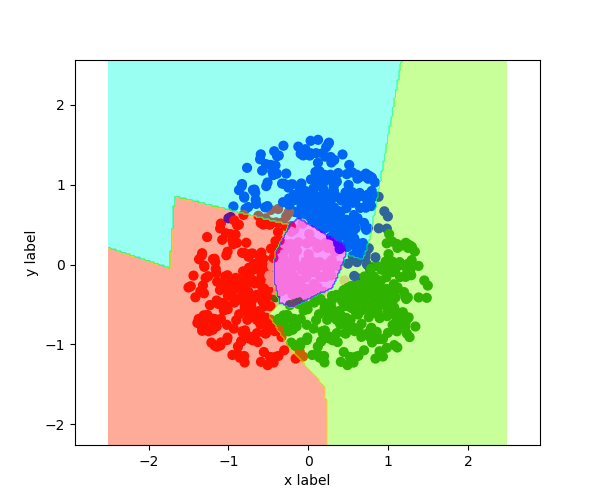

In [39]:
network_bn = SequentialNetwork(
    specification=network_specification_bn,
)

# Use the same weights used in non-batch-normalization network
network_bn.layer_inference.layers[0]._W = copy.deepcopy(W01)
network_bn.layer_inference.layers[3]._W = copy.deepcopy(W02)

np.array_equal(W01, network_bn.layer_inference.layers[0].W) and\
np.array_equal(W02, network_bn.layer_inference.layers[3].W)

for i in range(MAX_TEST_TIMES):
    network_bn.train(X=X, T=T)
    if not (i % 1000): 
        print(f"iteration {i} Loss {network_bn.L}")
        
_x = range(len(network_bn.history))
_y = network_bn.history
xlabel = 'iterations (log scale)'
ylabel = 'loss'
title = "training error"
fig, ax = plot(_x, _y, title=title, xlabel=xlabel, ylabel=ylabel,figsize=(5,4))
ax.set_ylim(0.0, 1.5)
ax.set_xscale('log')

fig, ax = plt.subplots(figsize=(6,5)) 
x_grid, y_grid, predictions_bn = prediction_grid_2d(
    x_min, x_max, y_min, y_max, network_bn.predict
)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions_bn)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

---